# Music Genre Classification using Neural Networks
---
> Build a model that can classify the genre of music using neural networks. You would need to
extract information from the audio samples such as spectrograms, MFCC, etc. and then use a
model to classify the music genre.

## Dataset ~
> The dataset for this notebook can be downloaded from the following link,

**Link:** https://os.unil.cloud.switch.ch/fma/fma_metadata.zip

### Table of Contents¶
#### 1. Environment Setup
#### 2. Dataset Gathering
#### 3. Exploratory Data Analysis
#### 4. Dataset Preprocessing
#### 5. Model Evaluation
#### 6. Performance Measurement

# 1. Environment Setup:
---
> In this step, we have installed and imported all neccessary libraries required to proceed with the solution to the given problem statement.

In [1]:
import os
import sys
import ast
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as skl
import librosa.display
import tensorflow as tf
from tensorflow import keras
import IPython.display as ipd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import binary_accuracy
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler

# 2. Dataset Gathering
---
> In this step, we have gathered the dataset from kaggle and have verified its integrity.

In [2]:
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

In [3]:
tracks = load('../input/fma-metadata/fma_metadata/tracks.csv')
genres = load('../input/fma-metadata/fma_metadata/genres.csv')
features = load('../input/fma-metadata/fma_metadata/features.csv')
echonest = load('../input/fma-metadata/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

# 3. Exploratory Data Analysis
---
> In this step, we took a deeper look at the data, and checked if the data is properly gathered in the previous steps.

In [4]:
print('Tracks: {}, Artists: {}, Albums: {}, Genres: {}'.format(
    len(tracks), len(tracks['artist', 'id'].unique()),
    len(tracks['album', 'id'].unique()),
    sum(genres['#tracks'] > 0)))
mean_duration = tracks['track', 'duration'].mean()
print('Track Duration: {:.0f} days total, {:.0f} seconds average'.format(
    sum(tracks['track', 'duration']) / 3600 / 24,
    mean_duration))

Tracks: 106574, Artists: 16341, Albums: 14854, Genres: 161
Track Duration: 343 days total, 278 seconds average


In [5]:
dimensionality = mean_duration * 44000 * 2
print('Sample Dimensionality: {:.1e}'.format(dimensionality))
print('Number of Audio Samples: {:.1e}'.format(dimensionality * len(tracks)))

Sample Dimensionality: 2.4e+07
Number of Audio Samples: 2.6e+12


In [6]:
for subset in tracks['set', 'subset'].unique():
    indicator = tracks['set', 'subset'] <= subset
    print('{:6}: {:6} tracks  {:.1f} days'.format(
        subset.capitalize(), sum(indicator), sum(indicator) * 30 / 3600 / 24))

Small :   8000 tracks  2.8 days
Medium:  25000 tracks  8.7 days
Large : 106574 tracks  37.0 days


In [7]:
def isnull(column, df=tracks):
    if column[1] in ['tags', 'genres', 'genres_all']:
        return df[column].apply(lambda x: len(x) == 0)
    elif df.dtypes[column] == np.int64:
        return df[column] <= 0
    else:
        return df[column].isnull()

In [8]:
columns = [
    ('track', 'title'),
    ('track', 'genres_all'),
    ('track', 'genre_top'),
    ('track', 'duration'),
    ('track', 'listens'),
    ('album', 'title'),
    ('album', 'listens'),
    ('album', 'tags'),
    ('artist', 'name'),
    ('artist', 'location'),
]

non_null = ~isnull(columns[0])
for column in columns[1:]:
    non_null &= ~isnull(column)
tids = np.random.RandomState(42).permutation(tracks.index[non_null])[:8]

tracks.loc[tids, columns].head()

track                                          \
                             title      genres_all      genre_top duration   
track_id                                                                     
150073             Welcome to Asia         [2, 79]  International       81   
140943            Sleepless Nights        [322, 5]      Classical      246   
64604     i dont want to die alone   [32, 38, 456]   Experimental      138   
23500              A Life In A Day  [236, 286, 15]     Electronic      264   
131150               Yeti-Bo-Betty    [25, 12, 85]           Rock      124   

                                    album          \
         listens                    title listens   
track_id                                            
150073       683                  Reprise    4091   
140943      1777  Creative Commons Vol. 7   28900   
64604        830        Summer Gut String    7408   
23500       1149          A Life in a Day    6691   
131150       183     No Life After Crypts    3594   

                                                             \
                                                       tags   
track_id                                                      
150073               [world music, dubtronica, fusion, dub]   
140943    [classical, alternate, soundtrack, piano, cont...   
64604     [improvised, minimalist, noise, field recordin...   
23500     [idm, candlestick, romanian, candle, candlesti...   
131150    [richmond, fredericksburg, trash rock, virgini...   

                           artist                            
                             name                  location  
track_id                                                     
150073                   DubRaJah                    Russia  
140943             Dexter Britain            United Kingdom  
64604     Buildings and Mountains               Oneonta, NY  
23500            Candlestickmaker                   Romania  
131150                The Crypts!  Fredericksburg, VA 22401

In [9]:
tracks['track', 'license'].value_counts().head(10)

Attribution-Noncommercial-Share Alike 3.0 United States                          19250
Attribution-NonCommercial-NoDerivatives (aka Music Sharing) 3.0 International    17732
Attribution-NonCommercial-ShareAlike 3.0 International                           15260
Creative Commons Attribution-NonCommercial-NoDerivatives 4.0                     12133
Attribution-Noncommercial-No Derivative Works 3.0 United States                  10584
Attribution-NonCommercial-ShareAlike                                              6907
Attribution                                                                       4991
Attribution-NonCommercial 3.0 International                                       3570
Attribution-NonCommercial                                                         3409
Attribution-ShareAlike                                                            1549
Name: (track, license), dtype: int64

In [10]:
tracks['track', 'language_code'].value_counts().head(10)

en    14255
es      204
fr      191
pt       81
de       68
ru       30
it       28
tr       25
sr       23
he       12
Name: (track, language_code), dtype: int64

#### Technical overview

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    106574.000000
mean        277.849100
std         305.518553
min           0.000000
25%         149.000000
50%         216.000000
75%         305.000000
max       18350.000000
Name: (track, duration), dtype: float64

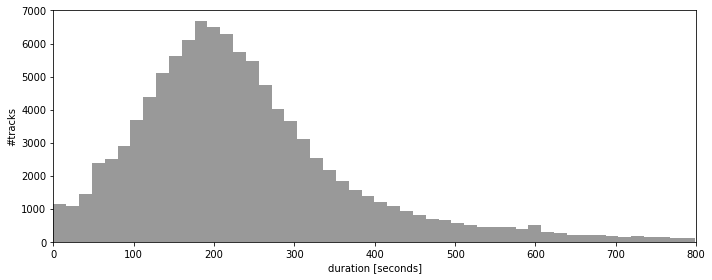

In [11]:
durations = tracks['track', 'duration']
plt.figure(figsize=(10, 4))  # Poster: (7, 3)
p = sns.distplot(durations[durations.values < 800], kde=False, rug=False, color='k', hist_kws=dict(alpha=0.4))
p.set_xlabel('duration [seconds]')
p.set_ylabel('#tracks')
p.set_xlim(0, 800)  # Poster: 500
plt.tight_layout()

durations.describe()

Common bit rates: [320000, 256000, 192000, 128000, 160000]
Average bit rate: 263 kbit/s


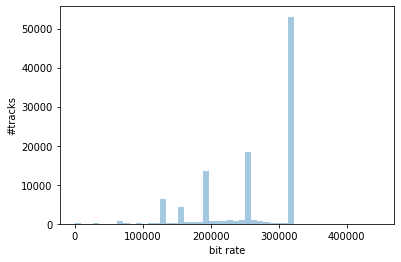

In [12]:
# Uncommon bit rates are VBR encodings

print('Common bit rates: {}'.format(tracks['track', 'bit_rate'].value_counts().head(5).index.tolist()))
print('Average bit rate: {:.0f} kbit/s'.format(tracks['track', 'bit_rate'].mean()/1000))
p = sns.distplot(tracks['track', 'bit_rate'], kde=False, rug=False)
p.set_xlabel('bit rate')
p.set_ylabel('#tracks');

#### Overview of user data

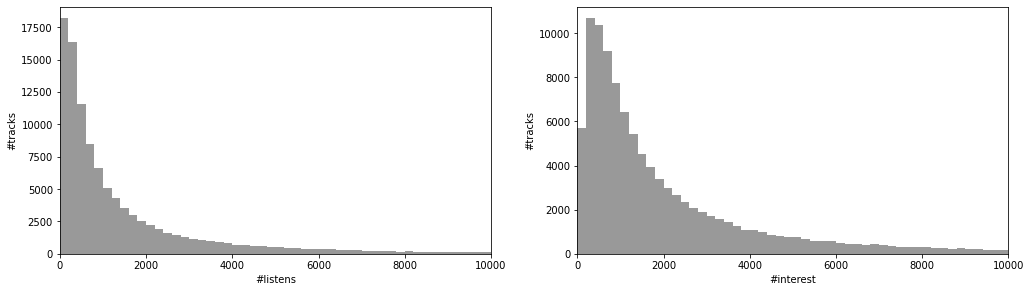

In [13]:
# Listens, favorites, comments.

def plot(col0, col1, maxval, subplot=None):
    if col0 == 'track':
        d = tracks['track']
    if col0 in ['artist', 'album']:
        d = tracks[col0].drop_duplicates('id')
    if subplot:
        plt.subplot(subplot)
    d = d[col1]
    p = sns.distplot(d[d.values < maxval], kde=False, color='k', hist_kws=dict(alpha=0.4))
    p.set_xlim(-1, maxval)
    p.set_xlabel('#' + col1)
    p.set_ylabel('#' + col0 + 's')

plt.figure(figsize=(17, 10))
plot('track', 'listens', 10e3, 221)
plot('track', 'interest', 10e3, 222)

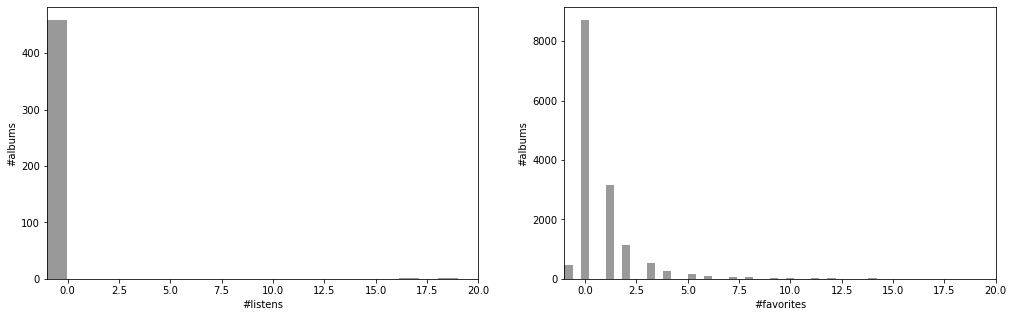

In [14]:
plt.figure(figsize=(17, 5))
plot('album', 'listens', 20, 121)
plot('album', 'favorites', 20, 122)

#### Overview of artists and respective albums

15891    745
7168     604
129      499
19461    416
2008     371
Name: (artist, id), dtype: int64

-1        1025
 17509     310
 2275      151
 21841     150
 13010     139
Name: (album, id), dtype: int64

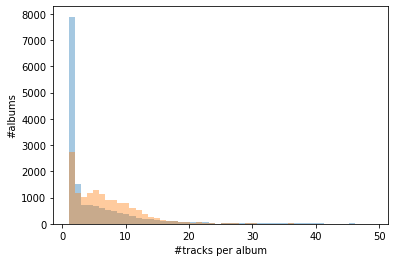

In [15]:
for effect in ['artist', 'album']:
    d = tracks[effect, 'id'].value_counts()
    ipd.display(d.head(5))
    p = sns.distplot(d[(d.values < 50) & (d.values >= 0)], kde=False)
    p.set_xlabel('#tracks per ' + effect);
    p.set_ylabel('#' + effect + 's');

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


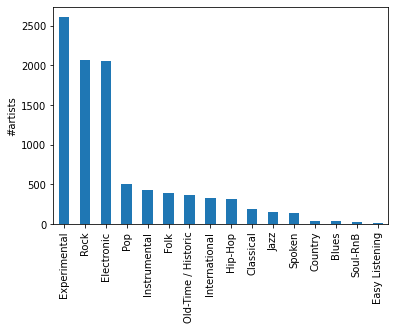

In [16]:
counts = pd.Series(index=genres.loc[genres['parent'] == 0, 'title'].values, name='#artists')
for genre in counts.index:
    counts[genre] = len(tracks.loc[tracks['track', 'genre_top'] == genre, ('artist', 'id')].unique())
counts.sort_values(ascending=False).plot.bar()
plt.ylabel('#artists');

#### Overview of genres and respective tracks

In [17]:
a = set(tracks['track', 'genre_top'].unique().dropna())
b = set(genres.loc[genres['top_level'].unique(), 'title'].values)
assert a == b

print('{} top-level genres'.format(len(a)))
genres[genres['parent'] == 0].sort_values('#tracks', ascending=False)

16 top-level genres


#tracks  parent                title  top_level
genre_id                                                 
38          38154       0         Experimental         38
15          34413       0           Electronic         15
12          32923       0                 Rock         12
1235        14938       0         Instrumental       1235
10          13845       0                  Pop         10
17          12706       0                 Folk         17
21           8389       0              Hip-Hop         21
2            5271       0        International          2
4            4126       0                 Jazz          4
5            4106       0            Classical          5
9            1987       0              Country          9
20           1876       0               Spoken         20
3            1752       0                Blues          3
14           1499       0             Soul-RnB         14
8             868       0  Old-Time / Historic          8
13            730       0       Easy Listening         13

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(1, 38154)

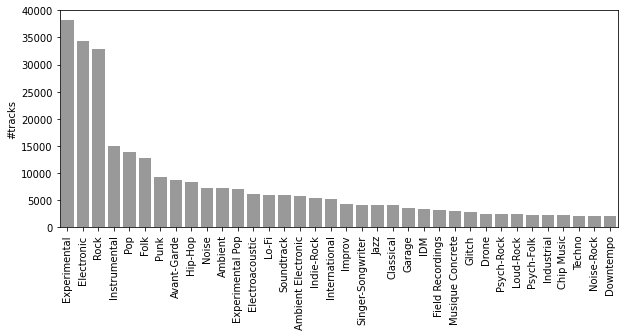

In [18]:
# Number of tracks per genre

d = genres[genres['#tracks'] > 2000].sort_values('#tracks', ascending=False)  # Poster: 5000
plt.figure(figsize=(10, 4))  # Poster: (7, 4)
p = sns.barplot('title', '#tracks', data=d, color='k', alpha=0.4)
p.set_xlabel('')
p.set_ylabel('#tracks')
plt.xticks(rotation=90)

genres.loc[genres['#tracks'] > 0, '#tracks'].min(), genres['#tracks'].max()

#### Cross-appearance

In [19]:
enc = MultiLabelBinarizer()
genres_indicator = enc.fit_transform(tracks['track', 'genres'])
genres_names = enc.classes_
genres_names = genres.loc[enc.classes_, 'title'].values
cross_correlation = genres_indicator.T @ genres_indicator

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


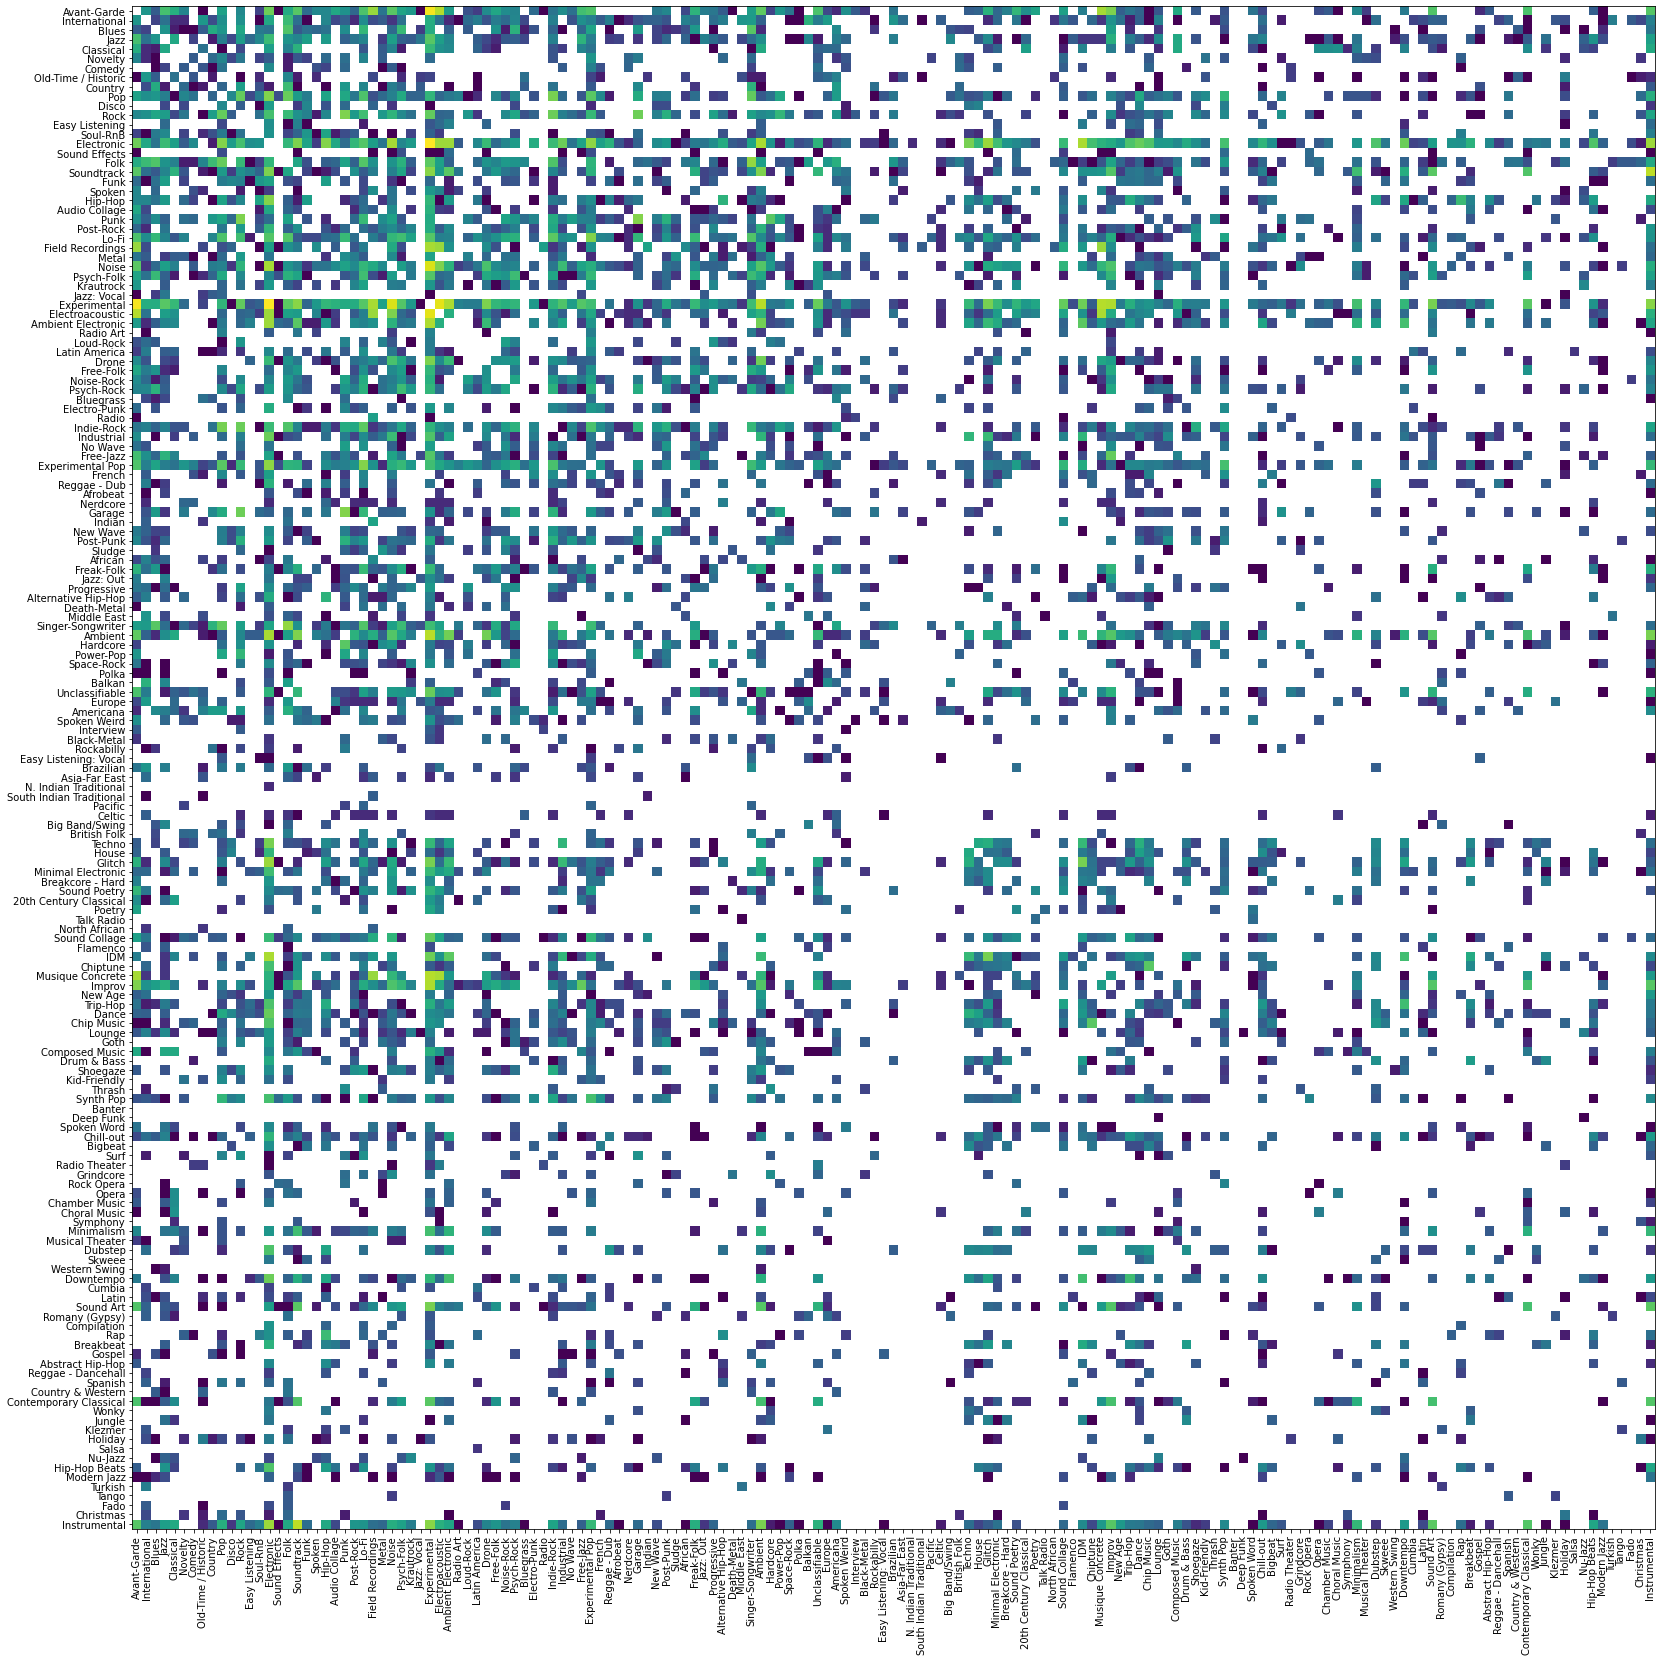

In [20]:
np.fill_diagonal(cross_correlation, 0)

plt.figure(figsize=(28, 28))
plt.imshow(np.log(cross_correlation))
plt.yticks(range(len(genres_names)), genres_names);
plt.xticks(range(len(genres_names)), genres_names, rotation=90);

#### Overview of the features

In [21]:
features.head(5).style.format('{:.2f}')

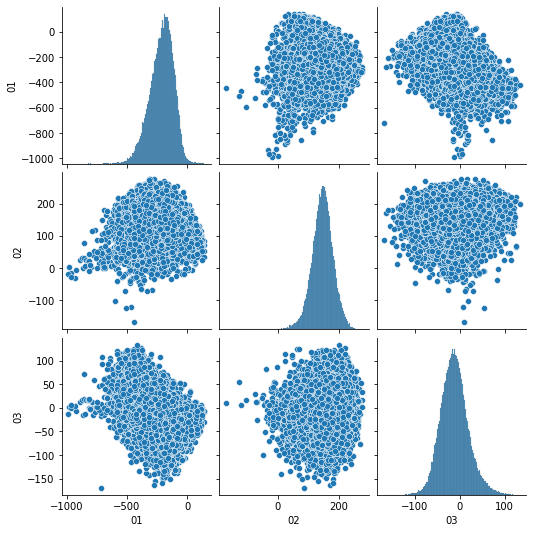

In [22]:
sns.pairplot(features['mfcc']['mean'].iloc[:, 0:3]);

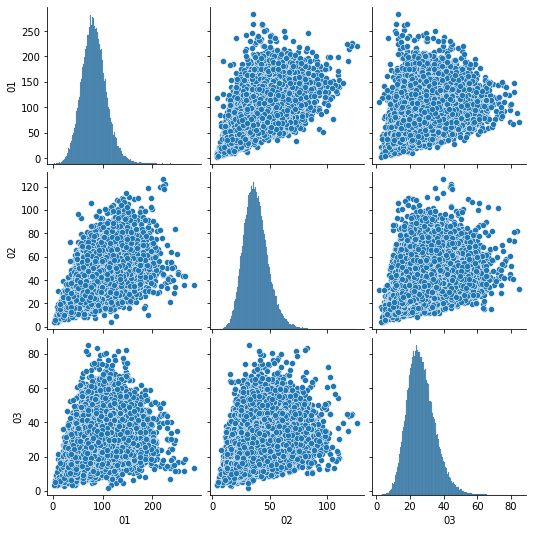

In [23]:
sns.pairplot(features['mfcc']['std'].iloc[:, 0:3]);

In [24]:
print('Echonest features available for {} tracks.'.format(len(echonest)))
ipd.display(echonest['echonest', 'audio_features'].head())

Echonest features available for 13129 tracks.


acousticness  danceability    energy  instrumentalness  liveness  \
track_id                                                                     
2             0.416675      0.675894  0.634476          0.010628  0.177647   
3             0.374408      0.528643  0.817461          0.001851  0.105880   
5             0.043567      0.745566  0.701470          0.000697  0.373143   
10            0.951670      0.658179  0.924525          0.965427  0.115474   
134           0.452217      0.513238  0.560410          0.019443  0.096567   

          speechiness    tempo   valence  
track_id                                  
2            0.159310  165.922  0.576661  
3            0.461818  126.957  0.269240  
5            0.124595  100.260  0.621661  
10           0.032985  111.562  0.963590  
134          0.525519  114.290  0.894072

# 4. Data Preprocessing:
---
> In this step, we have cleaned the data thus obtained for the previous steps before splitting them into training and testing datasets.

In [25]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

encoder = skl.preprocessing.LabelEncoder()
y_train = encoder.fit_transform(tracks.loc[small & train, ('track', 'genre_top')])
y_test = encoder.fit_transform(tracks.loc[small & test, ('track', 'genre_top')])
y_val = encoder.fit_transform(tracks.loc[small & val, ('track', 'genre_top')])

X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']
X_val = features.loc[small & val, 'mfcc']

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

6400 training examples, 800 testing examples
140 features, 8 classes


In [26]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)
scaler.transform(X_val)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


array([[-0.15511561, -0.49674298, -0.16143007, ...,  0.91561944,
         0.96924439, -0.54297993],
       [ 0.06436392, -0.45056024,  0.06710116, ..., -0.75143045,
        -0.7469227 , -0.84153531],
       [-0.26499075, -0.40794633,  0.2436578 , ...,  0.02336005,
        -0.45555942, -0.25568189],
       ...,
       [-0.31697505, -0.67543033, -0.4091746 , ..., -0.09201176,
         0.25387012, -0.08211476],
       [-0.28037183, -0.73526121,  2.26467868, ...,  1.08658067,
         0.51588351,  1.88342153],
       [ 0.05569623, -0.59821822, -0.58312677, ..., -0.61566561,
        -0.77430828, -0.66246204]])

# 5. Model Evaluation:
---
> In this step, we have trained the model using dense layers. Since our labels are not one-hot encoded we have used sparse categorical crossentropy along with Adadelta optimizer.

In [27]:
model = Sequential()
model.add(Dense(X_train.shape[0], activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(1024, activation='linear'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='linear'))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dense(8, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adadelta(), metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6400)              902400    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              6554624   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 5

2022-06-17 14:01:08.691320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 14:01:08.699712: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 14:01:08.700441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 14:01:08.701329: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [28]:
model.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=32,epochs=50)

2022-06-17 14:01:09.719423: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
200/200 [==============================] - 2s 4ms/step - loss: 1.9881 - sparse_categorical_accuracy: 0.2375 - val_loss: 1.8140 - val_sparse_categorical_accuracy: 0.3237
Epoch 2/50
200/200 [==============================] - 1s 3ms/step - loss: 1.8182 - sparse_categorical_accuracy: 0.3489 - val_loss: 1.6932 - val_sparse_categorical_accuracy: 0.3625
Epoch 3/50
200/200 [==============================] - 1s 3ms/step - loss: 1.7258 - sparse_categorical_accuracy: 0.3842 - val_loss: 1.6240 - val_sparse_categorical_accuracy: 0.3875
Epoch 4/50
200/200 [==============================] - 1s 3ms/step - loss: 1.6681 - sparse_categorical_accuracy: 0.4064 - val_loss: 1.5804 - val_sparse_categorical_accuracy: 0.4087
Epoch 5/50
200/200 [==============================] - 1s 3ms/step - loss: 1.6259 - sparse_categorical_accuracy: 0.4245 - val_loss: 1.5454 - val_sparse_categorical_accuracy: 0.4300
Epoch 6/50
200/200 [==============================] - 1s 3ms/step - loss: 1.5860 - sparse_categorica

# 6. Performance Measurement
---
> In this step, we have evaluated the performance measure of the model.

In [29]:
pred = np.argmax(model.predict(X_test), axis=1)

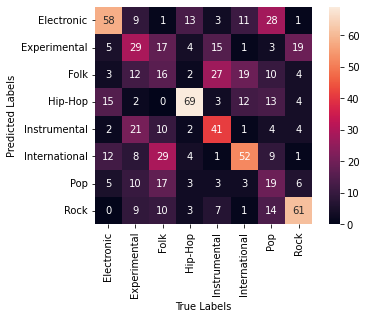

In [30]:
# Plotting the confusion matrix

import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, accuracy_score
mat = confusion_matrix(y_test, pred)
sns.heatmap(mat.T, square = True, annot = True, fmt = "d", xticklabels = np.unique(tracks.loc[small & test, ('track', 'genre_top')]), yticklabels = np.unique(tracks.loc[small & test, ('track', 'genre_top')]))
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.show()

In [31]:
# Measuring Accuracy

from sklearn import metrics

'''
    '0' : 'Electronic',
    '1' : 'Experimental',
    '2' : 'Folk',
    '3' : 'Hip-Hop',
    '4' : 'Instrumental',
    '5' : 'International',
    '6' : 'Pop',
    '7' : 'Rock'
'''

print(metrics.classification_report(y_test, pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.47      0.58      0.52       100
           1       0.31      0.29      0.30       100
           2       0.17      0.16      0.17       100
           3       0.58      0.69      0.63       100
           4       0.48      0.41      0.44       100
           5       0.45      0.52      0.48       100
           6       0.29      0.19      0.23       100
           7       0.58      0.61      0.60       100

    accuracy                           0.43       800
   macro avg       0.42      0.43      0.42       800
weighted avg       0.42      0.43      0.42       800



#### Comparing with the standard proposed models

In [32]:
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [33]:
# Support Vector Classification
sgd = SVC(kernel='rbf')
sgd.fit(X_train, y_train)
score = sgd.score(X_test, y_test)
print('SVC Accuracy: {:.2%}'.format(score))
sgd_pred = sgd.predict(X_test)

# Linear Support Vector Classification
lsgd = LinearSVC()
lsgd.fit(X_train, y_train)
score = lsgd.score(X_test, y_test)
print('Linear SVC Accuracy: {:.2%}'.format(score))
lsgd_pred = lsgd.predict(X_test)

# KNN Classification
knn = KNeighborsClassifier(n_neighbors=200)
knn.fit(X_train, y_train)
score = knn.score(X_test, y_test)
print('KNN Accuracy: {:.2%}'.format(score))
knn_pred = knn.predict(X_test)

# Random Forest Classification
rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
rf.fit(X_train, y_train)
score = rf.score(X_test, y_test)
print('Random Forest Accuracy: {:.2%}'.format(score))
rf_pred = rf.predict(X_test)

# AdaBoost Classification
adb = AdaBoostClassifier(n_estimators=10)
adb.fit(X_train, y_train)
score = adb.score(X_test, y_test)
print('AdaBoost Accuracy: {:.2%}'.format(score))
adb_pred = adb.predict(X_test)

# MLP Classification
mlp = MLPClassifier(hidden_layer_sizes=(200, 50), max_iter=2000)
mlp.fit(X_train, y_train)
score = mlp.score(X_test, y_test)
print('MLP Accuracy: {:.2%}'.format(score))
mlp_pred = mlp.predict(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


SVC Accuracy: 46.38%


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that

Linear SVC Accuracy: 43.25%
KNN Accuracy: 36.88%


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.

Random Forest Accuracy: 32.88%


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


AdaBoost Accuracy: 29.25%
MLP Accuracy: 42.38%


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


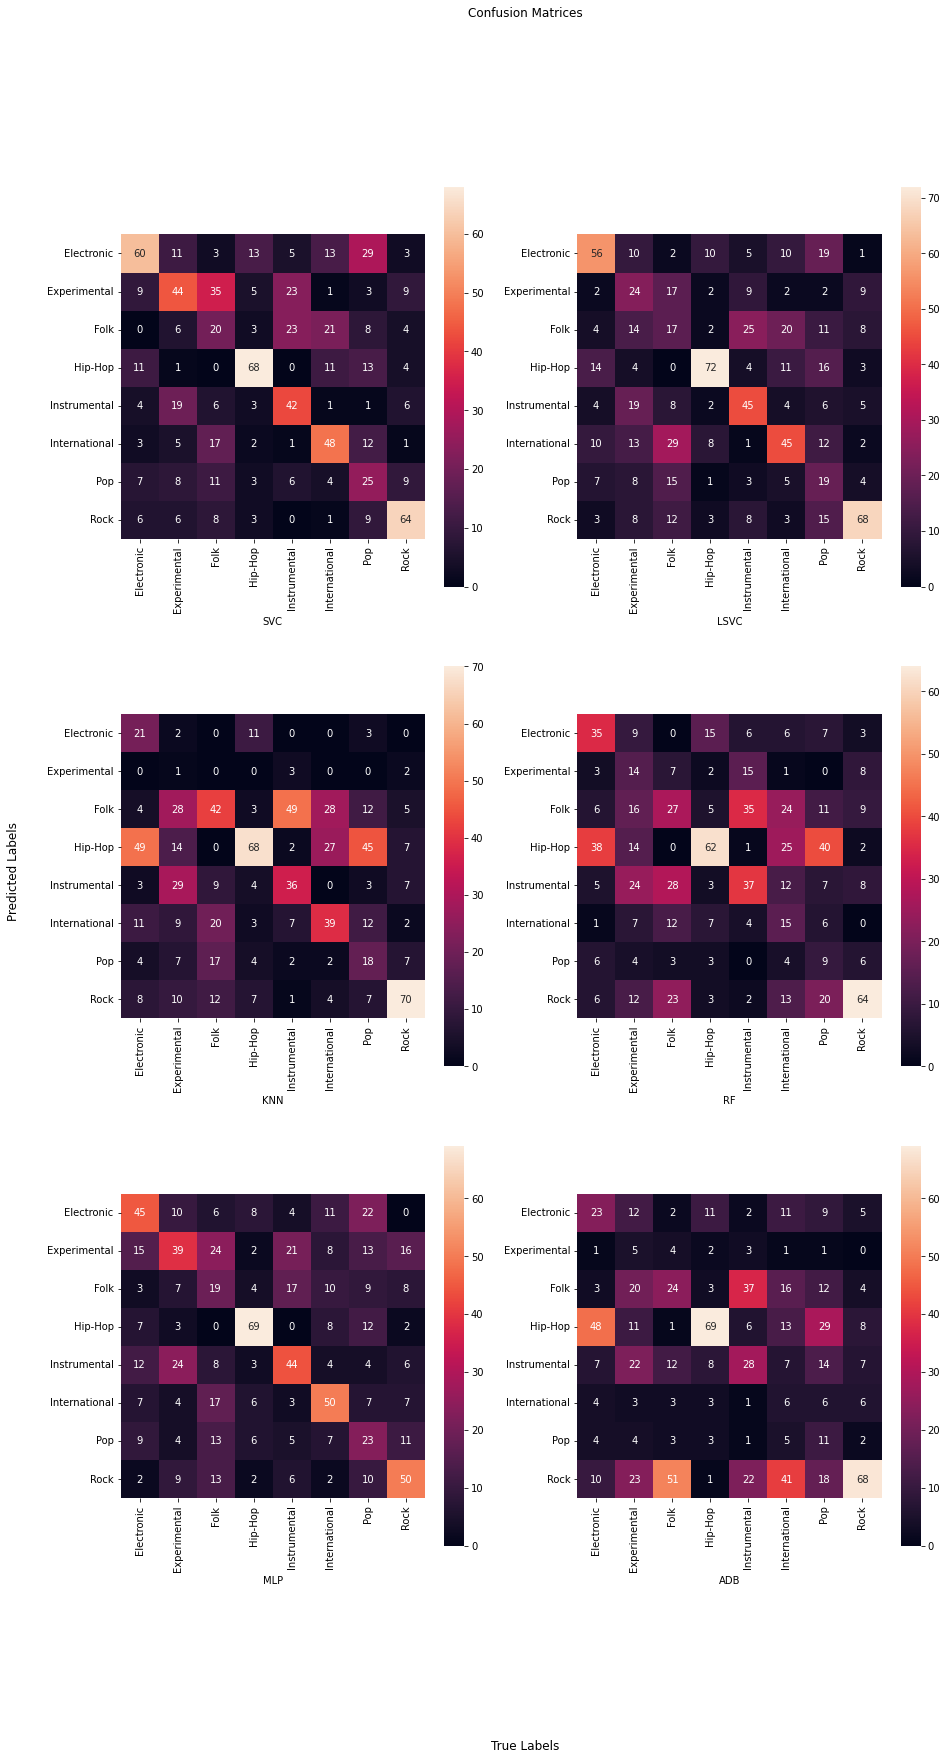

In [34]:
# Plotting the confusion matrix

import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, accuracy_score

fig, ax = plt.subplots(3,2, figsize=(15, 25))
fig.suptitle('Confusion Matrices')
fig.supxlabel('True Labels')
fig.supylabel('Predicted Labels')


mat = confusion_matrix(y_test, sgd_pred)
s1 = sns.heatmap(mat.T, square = True, annot = True, fmt = "d", xticklabels = np.unique(tracks.loc[small & test, ('track', 'genre_top')]), yticklabels = np.unique(tracks.loc[small & test, ('track', 'genre_top')]), ax=ax[0][0])
s1.set(xlabel='SVC')

mat = confusion_matrix(y_test, lsgd_pred)
s2 = sns.heatmap(mat.T, square = True, annot = True, fmt = "d", xticklabels = np.unique(tracks.loc[small & test, ('track', 'genre_top')]), yticklabels = np.unique(tracks.loc[small & test, ('track', 'genre_top')]), ax=ax[0][1])
s2.set(xlabel='LSVC')

mat = confusion_matrix(y_test, knn_pred)
s3 = sns.heatmap(mat.T, square = True, annot = True, fmt = "d", xticklabels = np.unique(tracks.loc[small & test, ('track', 'genre_top')]), yticklabels = np.unique(tracks.loc[small & test, ('track', 'genre_top')]), ax=ax[1][0])
s3.set(xlabel='KNN')

mat = confusion_matrix(y_test, rf_pred)
s4 = sns.heatmap(mat.T, square = True, annot = True, fmt = "d", xticklabels = np.unique(tracks.loc[small & test, ('track', 'genre_top')]), yticklabels = np.unique(tracks.loc[small & test, ('track', 'genre_top')]), ax=ax[1][1])
s4.set(xlabel='RF')

mat = confusion_matrix(y_test, mlp_pred)
s5 = sns.heatmap(mat.T, square = True, annot = True, fmt = "d", xticklabels = np.unique(tracks.loc[small & test, ('track', 'genre_top')]), yticklabels = np.unique(tracks.loc[small & test, ('track', 'genre_top')]), ax=ax[2][0])
s5.set(xlabel='MLP')

mat = confusion_matrix(y_test, adb_pred)
s6 = sns.heatmap(mat.T, square = True, annot = True, fmt = "d", xticklabels = np.unique(tracks.loc[small & test, ('track', 'genre_top')]), yticklabels = np.unique(tracks.loc[small & test, ('track', 'genre_top')]), ax=ax[2][1])
s6.set(xlabel='ADB')

plt.show()

#### Testing on an audio sample

In [35]:
def get_audio_path(audio_dir, track_id):
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str + '.mp3')

#### Audio Sample - 1
> For the first sample, we have chosen 'Rauf & Faik - детство', a viral russian pop and electronic song.

In [36]:
AUDIO_DIR = '../input/sample-audio/'
filename = get_audio_path(AUDIO_DIR, 1)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 0, 30
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: ../input/sample-audio/000001.mp3


/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Duration: 124.18s, 5476352 samples


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


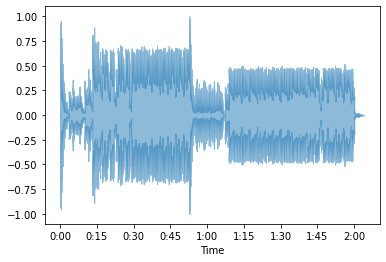

In [37]:
librosa.display.waveshow(x, sr, alpha=0.5);

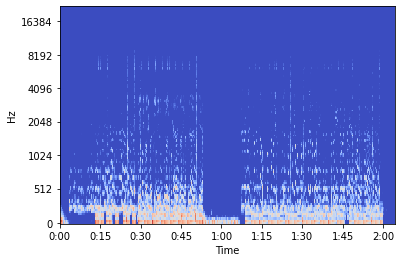

In [38]:
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
log_mel = librosa.amplitude_to_db(mel)

librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel');

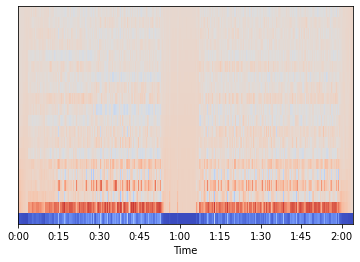

In [39]:
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
mfcc = skl.preprocessing.StandardScaler().fit_transform(mfcc)
librosa.display.specshow(mfcc, sr=sr, x_axis='time');

In [40]:
dict = {
    '0' : 'Electronic',
    '1' : 'Experimental',
    '2' : 'Folk',
    '3' : 'Hip-Hop',
    '4' : 'Instrumental',
    '5' : 'International',
    '6' : 'Pop',
    '7' : 'Rock'
}
sample = np.resize(mfcc, (mfcc.size//140, 140))
pred = np.argmax(model.predict(sample), axis=1)
freq = {}
for i in pred:
    if i not in freq:
        freq[i] = 0
    else:
        freq[i] += 1
freq = sorted(freq.items(), key=lambda x:x[1], reverse=True)
freq[1][0]
print('Predicted Genres: ', end='')
for i in range(2):
    print(dict[str(freq[i][0])],'/', end=' ')
print(dict[str(freq[2][0])])

Predicted Genres: International / Electronic / Pop
